# Autograd

In [53]:
import torch

This step creates a tensor and sets requires_grad to true.  
This turns on automatic differentiation, as a means to do back propogation

In [105]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Now two operations are made, where y is an operation made on x and z is an operation made on y.

In [106]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward>)


In [107]:
z = y * y * 3
print(z)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward>)


In [108]:
out = z.mean()
print(z)
print(out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward>)
tensor(27., grad_fn=<MeanBackward1>)


Now we backward propogate, and see that we end up with the result 4.5 , which is the derivitive of th output.  

In [103]:
out.backward()

In [104]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


We can also try to set backward to 2 (defaults to 1), and see the result is multiplied by two.

In [115]:
# change here
grad = torch.tensor(2.0)

#reset
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out = z.mean()

# propogate with custom grad
out.backward(grad)
print(x.grad)

tensor([[9., 9.],
        [9., 9.]])


# Building neural networks
This is where the neural network is created, and tested with some random dummy data.  
In this step, it is important to match all layers with the expected input and output.  

In this case, the matching has to be calculated for the convulutional layers.  
Remember, that pooling also changes the output dimensions

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [264]:
def CalcPooling(input_dim,kernel_dim,stride,dilation=1,padding=0):
    result = int(((input_dim+2*padding-dilation*(kernel_dim-1)-1)/stride)+1)
    return result

In [265]:
def CalcDimensionality(input_dim,kernel_dim,stride,padding=0):
    result = int(((input_dim-kernel_dim+2*padding)/stride)+1)
    return result

In [283]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        
        # calculate dimensions after first conv
        self.height1 = CalcDimensionality(input_dim=32,kernel_dim=5,stride=1)
        self.width1 = CalcDimensionality(input_dim=32,kernel_dim=5,stride=1)
        # calculate dimensions after first pooling
        self.height1 = CalcPooling(self.height1,kernel_dim=2,stride=2)
        self.width1 = CalcPooling(self.width1,kernel_dim=2,stride=2)
        
        #calculate dimensions after second conv layer
        self.height2 = CalcDimensionality(self.height1,5,1,0)
        self.width2 = CalcDimensionality(self.width1,5,1,0)
        # calculate dimensions after second pooling
        self.height2 = CalcPooling(self.height2,2,2)
        self.width2 = CalcPooling(self.width2,2,2)
        
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16*self.height2*self.width2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


At this point, the net is defined and we can put something through it.

In [240]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [284]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0240, -0.1219, -0.0742, -0.0509, -0.0875,  0.0139,  0.1274, -0.1394,
          0.0574,  0.1058]], grad_fn=<ThAddmmBackward>)


In [285]:
out.shape

torch.Size([1, 10])

In [286]:
net.zero_grad()
out.backward(torch.randn(1, 10))

# loss function
A loss function is a way of measuring how far the network is from target.  
In this case, we use means squared error.

In [287]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.4566, grad_fn=<MseLossBackward>)


# Backprop
Now, as the network ahs been defined, and we have a way to measure the performance against the dummy target, we can backpropogate to find the gradients.

In [288]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0014,  0.0002, -0.0063,  0.0093,  0.0120,  0.0008])


# Updating the wheights
In this example, a manual implementation of SGD is made

In [289]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [290]:
output = net(input)
loss = criterion(output, target)
print(loss)

tensor(0.4479, grad_fn=<MseLossBackward>)


The error has fallen. Now all that has to be done, is alot of epochs!

# Automatic optimizers
It is easier to use the build in optimizer packages

In [291]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

In [292]:
output = net(input)
loss = criterion(output, target)
print(loss)

tensor(0.4405, grad_fn=<MseLossBackward>)


# Aplying to real data
I will now load in the CIFAR10 dataset, and try to train the network on real data

## Importing the data

In [293]:
import torch
import torchvision
import torchvision.transforms as transforms


In [307]:
# The images are convertet to tensors, by normalizing the input.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


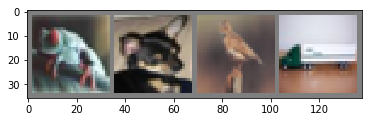

 frog   dog  bird truck


In [313]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define the network
Here we will make change the neural network definition, to take 3 channels as input.

In [353]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        
        # calculate dimensions after first conv
        self.height1 = CalcDimensionality(input_dim=32,kernel_dim=5,stride=1)
        self.width1 = CalcDimensionality(input_dim=32,kernel_dim=5,stride=1)
        # calculate dimensions after first pooling
        self.height1 = CalcPooling(self.height1,kernel_dim=2,stride=2)
        self.width1 = CalcPooling(self.width1,kernel_dim=2,stride=2)
        
        #calculate dimensions after second conv layer
        self.height2 = CalcDimensionality(self.height1,5,1,0)
        self.width2 = CalcDimensionality(self.width1,5,1,0)
        # calculate dimensions after second pooling
        self.height2 = CalcPooling(self.height2,2,2)
        self.width2 = CalcPooling(self.width2,2,2)
        
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16*self.height2*self.width2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Define optimizer
Here SGQ will be used, with a learning rate of 0.001 and a momentum of 0.9

In [354]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training
Now we can train the network, and see how it performs.

In [355]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.257
[1,  4000] loss: 1.969


Process Process-80:
Process Process-79:
  File "/home/bok/anaconda3/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bok/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/bok/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/bok/anaconda3/l

In [359]:
labels

tensor([4, 2, 0, 2])

In [360]:
outputs

tensor([[ 0.2026, -0.0273, -0.1271,  0.3296, -0.1114,  0.0410, -1.0651,  1.2950,
         -0.5957,  1.0617],
        [-0.7763, -0.6917,  0.7311,  1.1049,  0.8094,  0.8662,  0.8842,  0.6968,
         -1.5272, -0.3158],
        [-0.6683, -0.0744, -0.1364,  0.7237, -0.5851,  0.5872,  0.1527, -0.4390,
          0.5006,  0.0801],
        [-0.1041,  2.3408, -1.8025,  0.5108, -2.0875, -0.5279, -1.2483, -0.6447,
          1.0031,  2.4019]], grad_fn=<ThAddmmBackward>)

# Testing
Using 4 test images, we try to predict the correct label.

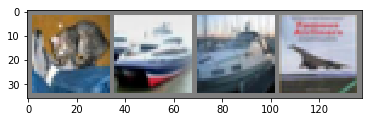

GroundTruth:    cat  ship  ship plane


Process Process-36:
Process Process-35:
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
Traceback (most recent call last):
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bok/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/bok/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._

In [321]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [323]:
outputs = net(images)

Because the network gives a propability (between 0 and 1) for each class, we have to take that into account, but choosing the category whith the highest propability (according to the network)

In [324]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The performance is not bad. It mastook the airplane for a ship, but it seems reasonable enough. Now lets test the performanc across the entire test data

In [325]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


We can also investigate what classes had the best performance

In [326]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 53 %
Accuracy of  bird : 45 %
Accuracy of   cat : 32 %
Accuracy of  deer : 29 %
Accuracy of   dog : 44 %
Accuracy of  frog : 65 %
Accuracy of horse : 70 %
Accuracy of  ship : 74 %
Accuracy of truck : 70 %


# Training on cuda
We actually have to transfer the network to the GPU to take advantage of it

In [343]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [347]:
net = net.to(device)

In [348]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [350]:
epochs = 3
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # Transfer to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.181
[1,  4000] loss: 1.903
[1,  6000] loss: 1.673
[1,  8000] loss: 1.592
[1, 10000] loss: 1.530
[1, 12000] loss: 1.499
[2,  2000] loss: 1.400
[2,  4000] loss: 1.400
[2,  6000] loss: 1.340
[2,  8000] loss: 1.321
[2, 10000] loss: 1.305
[2, 12000] loss: 1.293
[3,  2000] loss: 1.236
[3,  4000] loss: 1.202
[3,  6000] loss: 1.221
[3,  8000] loss: 1.227
[3, 10000] loss: 1.188
[3, 12000] loss: 1.202
Finished Training
